In [1]:
include("../code/exact_enum.jl")
include("../code/matrix_generator.jl")
include("../code/bp_full.jl")
include("../../telegram/notifications.jl")
using Base.Threads
nthreads()

22

In [2]:
function distortion_thresh(h, β, α=0.99)
    p = [h[i]*exp(-β*i) for i in eachindex(h)]
    p ./= sum(p)
    @assert α ≤ 1
    c = 0.0
    for i in eachindex(p)
        c += p[i]
        c ≥ α && return i-1
    end
    return lastindex(p)-1    
end

distortion_thresh (generic function with 2 methods)

In [3]:
# store independent variables of codewords with distortion smaller than `maxdistortion`
function codeword_graph(B, s::BitVector, maxdistortion::Int, ref::Integer;
    y = BitVector(undef, size(B,1)), x = BitVector(undef, size(B,2)))
    n, k = size(B)
    c = Int[]
    r = 64 * ( floor(Int, n/64) + 1)
    # extend B so that #rows is a multiple of 64 => easier for multiplication
    BB = [B; falses(r-n, k)]
    idx_ref = -1
    for i in 0:2^k-1
        i==ref && (idx_ref = length(c)+1)
        x.chunks[1] = i 
        bitmult_fast!(y, BB, x)
        d = distortion(y, s)
        d <= maxdistortion && push!(c, i)
    end
    @assert c[idx_ref] == ref
    c, idx_ref
end

codeword_graph (generic function with 1 method)

In [4]:
# connected component on the graph starting from `ref`. 
# two nodes are neighbors if at distance <= maxdistance
function connected_component(c::Vector{Int}, idx_ref::Int, maxdistance::Int, B;
        y = BitVector(undef, size(B,1)), x = BitVector(undef, size(B,2)),
        z = BitVector(undef, size(B,1)), t = BitVector(undef, size(B,2)))
    n, k = size(B)
    r = 64 * ( floor(Int, n/64) + 1 )
    # extend B so that #rows is a multiple of 64 => easier for multiplication
    BB = [B; falses(r-n, k)]
    visited = falses(length(c))
    Q = [idx_ref]
    prog = ProgressMeter.ProgressUnknown()
    while !isempty(Q)
        w = popfirst!(Q)
        visited[w] == true && continue
        visited[w] = true
        t.chunks[1] = c[w]
        bitmult_fast!(z, BB, t)
        for i in eachindex(c)
            visited[i] && continue
            x.chunks[1] = c[i]
            bitmult_fast!(y, BB, x)
            d = distortion(y, z)
            d <= maxdistance && push!(Q, i)
        end
        ProgressMeter.next!(prog, showvalues=[(:nvisited, "$(sum(visited))/$(length(c))")])
    end
    visited
end

connected_component (generic function with 1 method)

## Weight with $\beta$

In [5]:
R = 1//4
n = 16*5
@show n
m = round(Int, n*(1-R))
f3 = 1-3R
Λ = [0,1-f3,f3]
K = [0, 0, 1]
nedges = 3m 
H = permutedims(ldpc_matrix(n,m,nedges,Λ,K))
i = findfirst(isequal(2), vec(sum(H, dims=1)))
a = findfirst(!isequal(0), H[:,i])
H = H[[1:a-1; a+1:end], :]
B, indep = findbasis(H)
B = BitMatrix(B)
rtrue = size(B,2) // size(B,1)
# @assert R == rtrue
rng = MersenneTwister(0)
s = bitrand(rng, n);
# argmins = [0]
# _, h, mindist = exact_wef(B, [s], argmins=argmins)
# ref = argmins[1]
# maxdistortion = distortion_thresh(h[1], β)
# c, idx_ref = codeword_graph(B, s, maxdistortion, ref)

n = 80


In [6]:
sum(B, dims=1)

1×21 Matrix{Int64}:
 5  12  15  3  17  15  15  18  16  17  …  12  16  16  22  21  19  20  23  26

In [26]:
betas = 0.8:0.1:1.6
maxdistances = 1:25
sizes = [zeros(Int, length(maxdistances)) for _ in betas]
maxsizes = zeros(Int, length(betas))
cg = cgrad(:jet, length(betas), categorical=true)
markers =  [:circle, :rect, :star5, :diamond, :hexagon, :cross, :xcross, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x]
cc = [ [Int[] for _ in maxdistances] for _ in betas ]
@time begin
for i in eachindex(betas)
    β = betas[i]
    argmins = [0]
    _, h, mindist = exact_wef(BitMatrix(B), [s], argmins=argmins)
    ref = argmins[1]
    maxdistortion = distortion_thresh(h[1], β, 0.9)
    c, idx_ref = codeword_graph(BitMatrix(B), s, maxdistortion, ref)
    maxsizes[i] = length(c)
    for j in eachindex(maxdistances)
        d = maxdistances[j]
        cc[i][j] = findall(connected_component(c, idx_ref, d, BitMatrix(B)))
        if length(cc[i][j])==length(c)
            cc[i][j+1:end] = [c for _ in j+1:length(cc[i])] 
            break
        end
    end
    sizes[i] = [length(ccc) for ccc in cc[i]]
end
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/crotti/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Progress:  1047 	 Time: 0:00:00
  nvisited:  1047/1703

505.283685 seconds (3.78 M allocations: 279.436 MiB, 0.05% gc time, 0.01% compilation time)


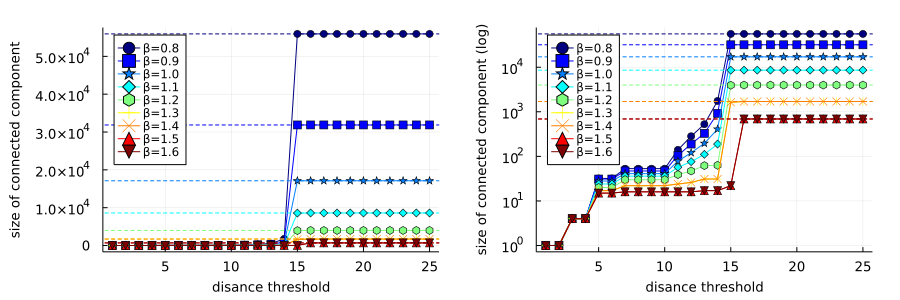

In [27]:
Plots.default(labelfontsize=9)
pl = plot()
for (i,β) in enumerate(betas)
    hline!(pl, [maxsizes[i]], ls=:dash, c=cg[i], label="")
    plot!(pl, maxdistances, sizes[i], label="β=$β", c=cg[i], m=markers[i])
end
p1 = plot(pl, legend=:topleft, xlabel="disance threshold", ylabel="size of connected component",
    size=(600,350))
p2 = plot(pl, legend=:topleft, xlabel="disance threshold", ylabel="size of connected component (log)",
    size=(600,350), yaxis=:log10)
plot(p1, p2, size=(900, 300), margin=5Plots.mm)

In [28]:
using IJuliaBell

@bell sleep(1)

<audio autoplay src="data:audio/wav;base64,UklGRrRiBQBXQVZFZm10IBAAAAABAAIARKwAABCxAgAEABAATElTVGgAAABJTkZPSUFSVBQAAABmcmVld2F2ZXNhbXBsZXMuY29tAElDUkQFAAAAMjAxNQAASU5BTRwAAABFLU11IFByb3RldXMgRlggQ29zbW9CZWwgQzMASVNGVA4AAABMYXZmNTcuODMuMTAwAGRhdGEgYgUA1//9/6X/9v+g//P/4v/0/40AGQCxAUgAHwOMAIYE0ADkBQkBlwYsAeMGOQHLBjQBHgYWAcwFCAEGBe0AxgTbAFsE1ADeA7YAgAOrAK0CgQALAmUA0wAyAOv/AwCH/sH/Qf2D/9b7S/9T+gz/4/jI/l/3hP7F9Uf+dfQC/r/ytP018Xb95e4T/Zztwfzx63T8cOoZ/N7p7vs46H77iOh3+1fnIPsT6Ar74ufq+oHoz/pM6d76s+mt+jXr5/px67/6kO4++6rvV/sM8777kPUM/LP4afxn/AH9Q/9J/VgD6f1PBjH+RgrV/twNR/96Ecz/mBVmAOgY1gBIHF4Btx/XAY4hGQKPJGQCiiNfApYjHQLRIigCSyHzAS0g0AEyHssBixyRAX4avAHDGK4BzRbsAUAVKAJ8E3ACRhLvAu8QbwM9EF8EZg8vBTsPawYUD8UHcw9GCQIQGgvoEO4M/BEED3wTYRH4FJUTCxeOFvwYTBm/G0Md4h1sICchMCWkIhwowCNaKUslZCymJUIteSZOL4MmbTCUJu0xECbOMmYlwTNCJF80zCLXNO8gEjW9HhU1RRzsNHUZbTR5Ft0zQhMRM+MPCDJVDNMwywiCLz0F7i21AUcsMP5XKtn6XSiY9zEmlPQAJKvxjSEJ7xYfpux3HJ/q0hnq6A0XjecwFJPmTBH45WAOq+VjC7/lZAgH5kgFp+ZGAojnPP+a6Cn83Oka+TrrDfaw7P7yNu4J8LjvAe1M8QvqyPIb5zP0MeR69VDhjfZ63l73ndv699bYMPgN1hz4W9PG97zQI/cpzi72p8v/9E3JifMGx93x58QC8PnCAu44wd/rmL+t6Tq+U+cAvQPl/7u24i67euCVulDeLbpP3AW6jdocugzZbbrR1/268tbLu27W5bxI1ja+hdbNvyHXqsEV2LfDhNkUxlHbxMiG3azLGeDQzgPjPdI+5tLVveml2W7tmd1J8a/hTPXc5Vb5FepJ/WDuOgG08hUFA/e3CEr7JgyN/1sPxwNaEvYHAxUJDGQXEBBzGfoTKBvUF3UckBtiHSwf9R2bIise8iUMHiYpnR0oLNIc9y7JG4cxiBr2MwgZJjZsFxo4vhXhOfwTajstEro8ZxDcPcgO2z4qDZo/pwsgQGYKlUBWCcRAhwjWQPEHvUCnB3RArgcaQPoHiz+MCN8+WwkNPmkKBT2tC+M7IA2nOqcOKDk/EKI32RHYNXsT+zMLFfExiBbDL+gXbC0kGfYqJhpbKOYaliVPG6UiVhuaHwAbYBxDGhMZExmZFXkXDxJ8FWYOHBO1ClcQ+AZADTED4Qlq/0IGo/ttAt73ev4w9Gv6ifBG9vvsJvKA6Q7uHeYL6uXiQebP377i5tye3zPa3tyu16TaYNXn2E7Totd40ffW9M/q1rDOZteZzYTY3cwy2lvMetwozEHfOMyB4obMNOYKzVDqu83N7svOo/MO0Kb4ZdHR/fzSAwOx1AkIhtbtDHvYgxF32qYVh9xmGZPeuRy14G0f0eJ0IdTk3yLf5pUj3+hUI6/qWyJ87JsgJu7mHbDvcxoa8TUWbPIuEYrzXguI9PQEZ/X9/Tv2l/bl9t3ud/f45v736d5n+ODWyfjnzh35KMdn+c2/sPnDuPL5O7Iv+oGsefqGp9v6SKM6+x+grvvnnTn8w5zc/NKcoP00nof+x6CM/4GksQB6qfABmK9UA5q2wwSrvkwGl8frB1LRnAnO21YL8OYjDZ7y5A6i/qIQ5QpaEkMXBxSjI6YVxi8sF5c7kBjZRtUZZVHvGvha8RuEY68cC2tFHXdxrx2ndt4d0XreHcV9sR1lf00d2n+9HP1+ARzPfAsbKnnWGVB0dxg6buIWzGYeFUFeMhOsVCQRJUrqDv0+tgxVM2wKeicpCF4b+QVUD+EDYgPMAbL32v9h7Bj+fuFu/DnX/fqazbT5rsSd+JC8rPdetQT3D6+E9s6pRPa/pT7226Jt9i2h5fbLoJ73fqGN+ECjrPkEpvz6wql1/FCuGv6Os9n/hrm0ARvApQMhx6IFlc6hB07WsAk73roLR+a6DVfuqg9U9oYRHv5NE5IF9xSKDHUWBRO8F+gY1RgxHsIZzyJzGtEm7hopKjIbxyw3G8UuARsjMIoa3DDfGe8w8BhtMNQXYS9/Fs8t+RTVK0gTdylsEcQmeA/LI2INrSA1C3Qd6AgyGpkG7RY8BMET0gGdEFX/lg3M/LkKSPr5B7f3YgUX9QkDhPLRAOnv0P5N7RH9w+qK+0zoLfrT5fz4dOPz9y3hGvf93lX269yz9f3a//Qm2Uj0ddee893VzvJs1OjxB9Pg8LrRte+C0Gnub8/17GzOWOuBzXvprcxt5/bLQ+Vcy/Xi8cp84JfK8N1fykbbUMqz2HXKINbLyqTTT8ta0RnMMs8MzUbNP86ly6TPVco20U/JDdOfyBbVTchP12HIvNnqyGLc5sk732rLQuJdzXfl38/h6NfSaew91iDwGNr781fe8vf64g783OcoAATtWgRk8qAI6ffhDIr9LBE0A28V4wipGYAOyh0HFPEhcRnnJakevymWI4gtLCgYMV8seDQkMLQ3gjO4Olc2eT2iOOU/kTooQu87IETRPNJFRj1ARzY9VUi8PCdJ3jusSao6A0ofORNKOTfISR41TEnMMqJIQjCmR58thUbuKiNFRyigQ50l3UEPI/M/mCDSPT4egzsBHBQ57BmANu0XnzMiFqkwhRSQLQ0TXCrGEQwnpxCVI60PASDWDmscJA7SGIMNJRXwDHARagy5DdoL+gkuCzEGbgp6An8JsP5gCNz6EwcH95IFL/PKA1PvwAFy63f/lufe/L/j9fng39T2F9xh81vYu++31OXrL9HU57DNtONvynffT8dF22nEGNe9wfXSR7/8zgy9L8sCu6vHQrlhxMy3WMF5trm+cbV2vLu0n7pPtD25LrRauE20CrjAtDC4arXguGu2JLrDt+G7TLkovii74cA/vRPEkb+sxyzCncv7xNLPAshE1DPL6diNzqfdCdKC4qrVZudo2UrsOd0h8STh4fUj5Vf6EumN/hntgwIU8QYG+/QrCdX44wuX/DUOSAAlENYDohFEB8ESmQpxE78NyhPHEOATtBOiE24WLRMAGYoSfRuvEdYdwRAAIL4PBiKtDuEjtw2nJQANUSdxDNsoJQxQKigMpSt1DNMsJA37LTEOCC+gD/wvaxHIMJ8TfDEtFiUyDBm1MjocJjOmH3gzSCOrMygnyzMkK8QzOi+bM1IzVTNMN+ky/zpOMmE+jDFuQaEw6EN+L+RFLy5aR8MsJUgfKyxIUCmHR1UnLkYjJdZDwSKeQDcgqzyHHcA3qRoQMqsXiyt/FDskMRErHMkNahNCCiQKtQZnABEDZ/Zu/y/s0/ve4U74oNfM9H3NcfGlwzXuNroW6yyxKejKqHflI6Hw4m2aueB/lLnetY8P3Q+MrNuMiZXaSIjR2WqIX9nviVTZu4yL2dKQH9pHlgTbwZwn3G2kpt0urXDfwbZe4UHBmeN6zPrlddiQ6PDkUuvM8Tju5/4s8REMJ/Q0GUD3JCZa+pUyTP1kPiYAUUnjAktTfgU5XOEHFmQHCrhq8gs6cKUNmHQlD513YxBYeV4R2XkDEt94ZhJ8doMSunJKErltzRFVZwQRoV/tD9hWmg7zTPoMOUIeC+c2EAkdK+EGBR+gBMwSNAKQBr//ePpB/ZPusvoA4yn45deg9VfNHfNjw6PwELoy7pmx4uv+qajpRqOP5

In [673]:
distortion_thresh(h[1], 1.0, 0.5) / n

0.2875

In [408]:
betas = reverse( 1 ./ (0.1:0.1:2) )
Eavg = zeros(length(betas))
for (i,β) in enumerate(betas)
    p = [h[1][i]*exp(-β*i) for i in eachindex(h[1])]
    p ./= sum(p)
    Eavg[i] = (eachindex(p) .- 1)'p / n
end

In [410]:
[betas Eavg]

20×2 Matrix{Float64}:
  0.5       0.375217
  0.526316  0.368719
  0.555556  0.361574
  0.588235  0.353704
  0.625     0.345034
  0.666667  0.335498
  0.714286  0.325064
  0.769231  0.313763
  0.833333  0.30174
  0.909091  0.289309
  1.0       0.276989
  1.11111   0.265473
  1.25      0.255485
  1.42857   0.247565
  1.66667   0.241883
  2.0       0.238224
  2.5       0.236108
  3.33333   0.234991
  5.0       0.234482
 10.0       0.234376

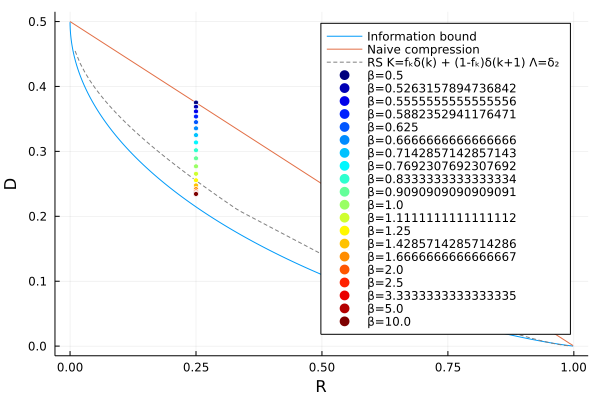

In [406]:
pp = plot_rdb()
cg = cgrad(:jet, length(betas), categorical=true)
for (i,β) in enumerate(betas)
    scatter!(pp, [R], [Eavg[i]], label="β=$β", ms=3, msc=:white, c=cg[i])
end
pp

In [478]:
sum(H, dims=1)

1×64 Matrix{Int64}:
 2  2  2  2  3  3  3  2  3  2  2  2  2  …  3  2  2  2  3  3  2  2  2  2  2  2

In [480]:
i = findfirst(isequal(2), vec(sum(H, dims=1)))
a = findfirst(!isequal(0), H[:,i])

27

In [579]:
function explore_cluster(R, n, maxdistances, nsources, β; 
        rng = MersenneTwister(0))
    m = round(Int, n*(1-R))
    f3 = 1-3R
    Λ = [0,1-f3,f3]
    K = [0, 0, 1]
    nedges = 3m 
    H = permutedims(ldpc_matrix(n,m,nedges,Λ,K, rng=rng))
#     i = findfirst(isequal(2), vec(sum(H, dims=1)))
#     a = findfirst(!isequal(0), H[:,i])
#     H = H[[1:a-1; a+1:end], :]
    B, indep = findbasis_slow(BitMatrix(H))
    rtrue = size(B,2) // size(B,1)
    @assert R == rtrue
    cc = Vector{Vector{Vector{Int64}}}(undef, nsources)
    @threads for i in 1:nsources
        Random.seed!(rng, i)
        s = bitrand(rng, n)
        argmins = [0]
        _, h, mindist = exact_wef(B, [s], argmins=argmins)
        ref = argmins[1]
        maxdistortion = distortion_thresh(h[1], β, 0.9)
        c, idx_ref = codeword_graph(B, s, maxdistortion, ref)
        cc[i] = [findall(connected_component(c, idx_ref, d, B)) for d in maxdistances]
    end
    cc
end

explore_cluster (generic function with 3 methods)

In [330]:
R = 1 // 4
n = 32*2

64

In [335]:
maxdistances = ceil.(Int, (0.00:0.01:0.13)*n)
nsources = 10
β = 0.5
cc = explore_cluster(R, n, maxdistances, nsources, β);

Progress:  38 	 Time: 0:00:00
  nvisited:  38/42463

In [423]:
maxdistances = 1:10

15-element Vector{Int64}:
 0
 1
 2
 2
 3
 4
 4
 5
 6
 6
 7
 8
 8
 9
 9

In [437]:
betas = [0, 0.1, 0.2, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0]
maxdistances = 1:11
sz_avg = [zeros(length(maxdistances)) for _ in betas]
sz_std = [zeros(length(maxdistances)) for _ in betas]
for (i,β) in enumerate(betas)
    cc = explore_cluster(R, n, maxdistances, nsources, β)
    sizes = [length.(ccc) for ccc in cc]
    sz_avg[i] = mean(sizes)
    sz_std[i] = std(sizes) ./ sqrt(nsources)
end

Progress:  247 	 Time: 0:00:00
Progress:  104 	 Time: 0:00:00
Progress:  113 	 Time: 0:00:00
Progress:  130 	 Time: 0:00:00
Progress:  129 	 Time: 0:00:00
  nvisited:  129/5040

In [438]:
pl = Plots.plot()
cg = cgrad(:matter, length(betas), categorical=true)
for (i,β) in enumerate(betas)
    plot!(pl, maxdistances, sz_avg[i], yerr=sz_std[i], xlabel="distance threshold", ylabel="size of connected component", 
        label="R=$(float(R)), n=$n, β=$β", legend=:topleft, m=:o, title="avg over $nsources sources",
        c = cg[i])
end

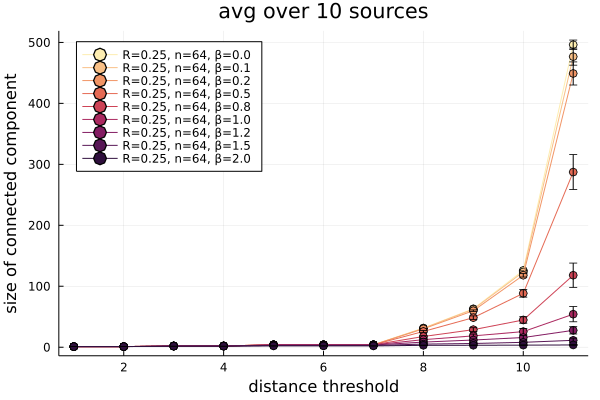

In [439]:
pl

In [336]:
sizes = [length.(ccc) for ccc in cc]
sizes_avg = mean(sizes)
sizes_std = std(sizes) ./ sqrt(nsources);

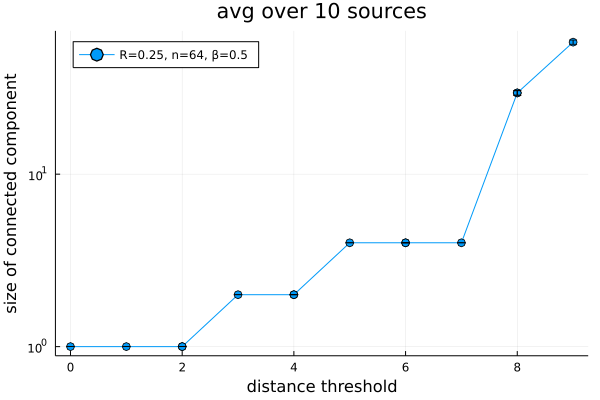

In [337]:
pl = plot(maxdistances, sizes_avg, yerr=sizes_std, xlabel="distance threshold", ylabel="size of connected component", 
    label="R=$(float(R)), n=$n, β=$β", legend=:topleft, m=:o, title="avg over $nsources sources",
    yaxis=:log10)

In [183]:
R2 = 6 // 32
n2 = 128
nsources2 = 10
maxdistances2 = ceil.(Int, (0.01:0.01:0.17)*n2)
cc2 = explore_cluster(R2, n2, maxdistances2, nsources);

Progress:  372 	 Time: 0:00:20
  nvisited:  372/358427

In [184]:
sizes2 = [length.(ccc) for ccc in cc2]
sizes2_avg = mean(sizes2)
sizes2_std = std(sizes2) ./ sqrt(nsources2);;

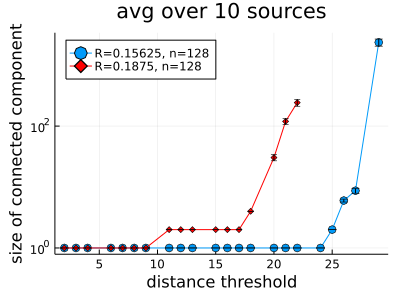

In [195]:
pl2 = plot!(deepcopy(pl), maxdistances2, sizes2_avg, yerr=sizes2_std, xlabel="distance threshold", 
    ylabel="size of connected component",
    label="R=$(float(R2)), n=$n2", legend=:topleft, m=:diamond, c=:red, yaxis=:log10, ms=3,
    size=(400,300))

In [51]:
function exact_wef_cluster(B, thresh::Real, s2, sources=BitVector[]; showprogress=true,
    y = BitVector(undef, size(B,1)),
    x = BitVector(undef, size(B,2)),
    h0 = zeros(Int, size(B,1)+1),
    h = [zeros(Int, size(B,1)+1) for _ in sources],
    mins = fill(size(B,1), length(sources)),
    argmins = fill(0, length(sources)))

    n, k = size(B)
    @assert all(x->length(x)==n, sources)
    @assert k < 64 "Adjust code for k larger than 64" 

    r = 64 * ( floor(Int, n/64) + 1)
    # extend B so that #rows is a multiple of 64 => easier for multiplication
    BB = [B; falses(r-n, k)]
    
    dt = showprogress ? 1.0 : Inf
    prog = ProgressMeter.Progress(2^k, dt=dt)
    for i in 0:2^k-1
        x.chunks[1] = i 
        bitmult_fast!(y, BB, x)
        d = hamming_weight(y)
        h0[d+1] += 1
        for (j,s) in enumerate(sources)
            d = distortion(y, s)
            if distortion(s, s2)/n < thresh
                h[j][d+1] += 1
                if d < mins[j]
                    mins[j] = d
                    argmins[j] = i
                end
            end
        end
        ProgressMeter.next!(prog)
    end
    h0, h, mins ./ n
end

exact_wef_cluster (generic function with 5 methods)

In [52]:
R = 5 // 32
n = 128
m = round(Int, n*(1-R))
f3 = 1-3R
Λ = [0,1-f3,f3]
K = [0, 0, 1]
nedges = 3m 
rng = MersenneTwister(0)
H = permutedims(ldpc_matrix(n,m,nedges,Λ,K, rng=rng))
s = bitrand(rng, n)
B, indep = findbasis_slow(BitMatrix(H))
rtrue = size(B,2) // size(B,1)
@assert R == rtrue
argmins = [0]
_, _, mindist = exact_wef(B, [s], argmins=argmins)

([1, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [0.3046875])

In [53]:
k = length(indep)
x = falses(k)
x.chunks[1] = argmins[1]
y = falses(n)
r = 64 * ( floor(Int, n/64) + 1)
BB = [B; falses(r-n, k)]
bitmult_fast!(y, BB, x)
@assert distortion(y, s) / n == mindist[1]

In [68]:
threshs = 0.1:0.1:1
hs = []
for (i, thresh) in enumerate(threshs)
    h0, h, mins = exact_wef_cluster(B, thresh, s, [y], showprogress=false)
    push!(hs, h[1])
end

┌ Warning: WEF vector is empty
└ @ Main /home/crotti/sourcecoding/code/exact_enum.jl:155
┌ Warning: WEF vector is empty
└ @ Main /home/crotti/sourcecoding/code/exact_enum.jl:155
┌ Warning: WEF vector is empty
└ @ Main /home/crotti/sourcecoding/code/exact_enum.jl:155


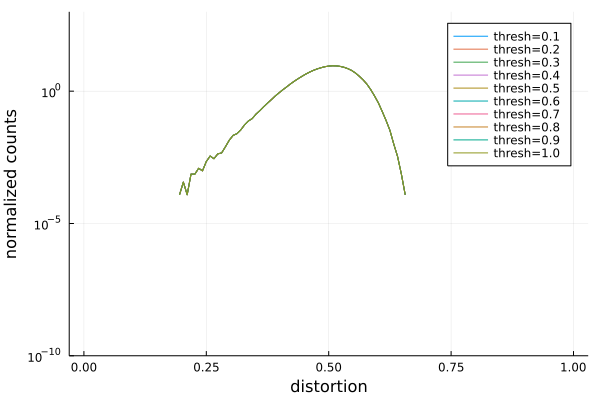

┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero valu

In [69]:
pl = Plots.plot()
for (i, thresh) in enumerate(threshs)
    plot_wef!(pl, hs[i], plotmin=false, label="thresh=$thresh",
            seriestype=:line, yaxis=(:log10, (1e-10,10^3)), titlefontsize=9, ms=1.5, msw=0)
end
pl